<a href="https://colab.research.google.com/github/hamednasr/CIFAR-10-classification/blob/main/PyTorch_CIFAR_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 classification using PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
trans = T.Compose([T.ToTensor()])

In [3]:
# device= 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [4]:
train = torchvision.datasets.CIFAR10(root = 'cifar10',download=True,transform=trans)
train

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
test = torchvision.datasets.CIFAR10(root = 'cifar10',train=False,download=True,transform=trans)
test

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test.data[11,:].shape

(32, 32, 3)

In [7]:
trans(test.data[11,:]).shape

torch.Size([3, 32, 32])

In [8]:
test.transform(test.data[11,:]).shape

torch.Size([3, 32, 32])

In [9]:
train.data.shape

(50000, 32, 32, 3)

In [10]:
test.data.shape

(10000, 32, 32, 3)

In [11]:
# trainlabel = train.targets

In [12]:
# testlabel = test.targets

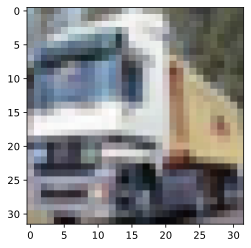

In [13]:
plt.imshow(train.data[1])

# data preparation for pytorch

In [14]:
train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [15]:
# traindata = traindata.reshape(traindata.shape[0],3,32,32)
# testdata = testdata.reshape(testdata.shape[0],3,32,32)

In [16]:
# traindataT = torch.tensor(traindata).float() 
# testdataT = torch.tensor(testdata).float() 

In [17]:
# trainlabelT = torch.tensor(trainlabel).long()
# testlabelT = torch.tensor(testlabel).long()

In [18]:
# traindataT.shape

In [19]:
# testdataT.shape

In [20]:
# trainlabelT

In [21]:
# traindata,testdata,trainlabel,testlabel=train_test_split(imagesT,labelsT,test_size=.1)

In [22]:
# trainset = TensorDataset(traindataT,trainlabelT)

In [23]:
# testset = TensorDataset(testdataT,testlabelT)

In [24]:
batchsize=128
trainloader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)

In [25]:
testloader = DataLoader(test,batch_size=10000)

## building model:

In [26]:
def CreateModel():
  
  class CNNmodel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,50,kernel_size=3,stride=1,padding=1) #first conv layer
      # (32+2*1-3)/1+1=32   max pool:32/2 = 16
      self.batchnorm1 = nn.BatchNorm2d(50)
      
      self.conv2 = nn.Conv2d(50,100,kernel_size=3,padding=1) #second conv layer
      #(16+2*1-3)/1+1 = 16  max pool: 16/2 = 8
      self.batchnorm2 = nn.BatchNorm2d(100)

      self.conv3 = nn.Conv2d(100,200,kernel_size=3) #third conv layer
      # # #(8+2*0-3)/1+1 = 6  max pool: 6/2 = 3
      self.batchnorm3 = nn.BatchNorm2d(200)

      self.fc1 = nn.Linear(3*3*200,400)

      self.fc2 = nn.Linear(400,100)

      self.out = nn.Linear(100,10)

    
    def forward(self,x):

      x = F.max_pool2d(self.conv1(x),2)
      x= F.leaky_relu(self.batchnorm1(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv2(x),2)
      x= F.leaky_relu(self.batchnorm2(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv3(x),2)
      x= F.leaky_relu(self.batchnorm3(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x, p=0.5, training = self.training)

      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x, p=0.5, training = self.training)
      
      x = self.out(x)      
      
      return x

  CNN = CNNmodel()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params=CNN.parameters(), lr = 0.001)

  return CNN, lossfun, optimizer

## Sanity checking of the model:

In [27]:
X = torch.randn(5,3,32,32)
CNN, lossfun, optimizer = CreateModel()
yhat = CNN(X)
print(yhat.shape)
print(torch.argmax(yhat,1))

torch.Size([5, 10])
tensor([6, 3, 6, 0, 0])


## Train the model:

In [28]:
epochs = 10

def TrainModel():

  CNN, lossfun, optimizer = CreateModel()
  CNN.to(device)

  trainacc = []
  testacc = []
  trainloss = []
  testloss = []

  for i in range(epochs):
    
    CNN.train()

    batchloss = []
    batchacc = []

    for X, y in trainloader:

      X = X.to(device)
      y = y.to(device)
      
      yhat = CNN(X)

      loss = lossfun(yhat,y)
      batchloss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

      batchacc.append(100*torch.mean(((torch.argmax(yhat,1)==y).float())).item())

    trainloss.append(np.mean(batchloss))
    trainacc.append(np.mean(batchacc))

    CNN.eval()
    X,y = next(iter(testloader))
    X = X.to(device)
    y = y.to(device)
    yhat = CNN(X)
    testloss.append(lossfun(yhat,y).item())
    testacc.append( 100*torch.mean(((torch.argmax(yhat,1)==y).float())).item() )
    print(f'{i+1} of {epochs} epochs done.')

  return CNN, trainacc, testacc, trainloss, testloss

In [29]:
CNN, trainacc, testacc, trainloss, testloss = TrainModel()

1 of 10 epochs done.
2 of 10 epochs done.
3 of 10 epochs done.
4 of 10 epochs done.
5 of 10 epochs done.
6 of 10 epochs done.
7 of 10 epochs done.
8 of 10 epochs done.
9 of 10 epochs done.
10 of 10 epochs done.


## model evaluation

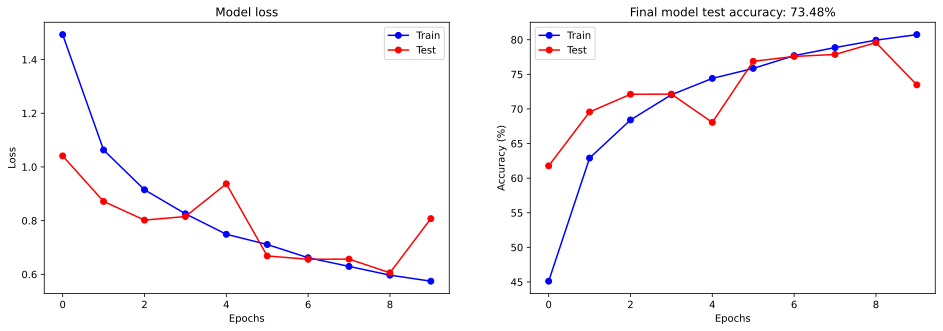

In [30]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss,'bo-',label='Train')
ax[0].plot(testloss,'ro-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainacc,'bo-',label='Train')
ax[1].plot(testacc,'ro-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testacc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [31]:
X,y = next(iter(testloader))
CNN.cpu()
yhat = CNN(X)
print('report:\n\n',classification_report(y,torch.argmax(yhat,1).detach()))

report:

               precision    recall  f1-score   support

           0       0.84      0.69      0.76      1000
           1       0.94      0.82      0.87      1000
           2       0.62      0.68      0.65      1000
           3       0.65      0.45      0.53      1000
           4       0.64      0.77      0.70      1000
           5       0.85      0.36      0.51      1000
           6       0.60      0.94      0.73      1000
           7       0.84      0.80      0.82      1000
           8       0.73      0.94      0.82      1000
           9       0.83      0.89      0.86      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = test.ta
cnf_matrix = confusion_matrix(y, yhat.detach())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()